In [1]:
# Run once at top of notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.utils import resample

# plotting defaults
plt.rcParams.update({'figure.max_open_warning': 0})


In [2]:
fn = 'cognitive_load_model_ready.csv'
df = pd.read_csv(fn)
print("shape:", df.shape)
print("columns:", df.columns.tolist())
print(df.head(10))


shape: (32, 14)
columns: ['academic_level', 'date', 'num_sessions', 'subject', 'session_duration_min', 'break_score', 'switch_score', 'deadline_weight', 'late_night', 'effort', 'focus', 'fatigue', 'studied_today', 'duration_missing']
  academic_level        date  num_sessions  subject  session_duration_min  \
0             PG  2025-12-19           2.0   Coding                 150.0   
1             PG  2025-12-19           1.0   Coding                  70.0   
2             UG  2025-12-19           NaN   Coding                   NaN   
3             PG  2025-12-19           2.0    Other                   NaN   
4             PG  2025-12-19           2.0   Coding                  63.0   
5             PG  2025-12-19           2.0   Coding                 260.0   
6             UG  2025-12-19           1.0   Coding                  60.0   
7             UG  2025-12-19           1.0  Reading                 150.0   
8             UG  2025-12-19           1.0    Other                  60.0

In [3]:
print("Missing counts for labels:")
print(df[['effort','focus','fatigue']].isnull().sum())


Missing counts for labels:
effort     32
focus       0
fatigue     0
dtype: int64


In [4]:
# Defensive: if effort has values, this still removes it intentionally.
if 'effort' in df.columns:
    df2 = df.drop(columns=['effort']).copy()
else:
    df2 = df.copy()

print("After dropping effort, columns:", df2.columns.tolist())


After dropping effort, columns: ['academic_level', 'date', 'num_sessions', 'subject', 'session_duration_min', 'break_score', 'switch_score', 'deadline_weight', 'late_night', 'focus', 'fatigue', 'studied_today', 'duration_missing']


In [5]:
# Make sure the column exists
if 'duration_missing' not in df2.columns:
    df2['duration_missing'] = df2['session_duration_min'].isna().astype(int)

# Fix NaNs and enforce consistency
df2['duration_missing'] = df2['duration_missing'].fillna(1).astype(int)
df2.loc[df2['session_duration_min'].isna(), 'duration_missing'] = 1
df2.loc[df2['session_duration_min'].notna(), 'duration_missing'] = df2.loc[df2['session_duration_min'].notna(), 'duration_missing'].fillna(0).astype(int)

print("duration_missing value counts:")
print(df2['duration_missing'].value_counts(dropna=False))

# Sanity: show any inconsistent rows (should be zero)
bad = df2[(df2['session_duration_min'].isna()) & (df2['duration_missing'] == 0)]
print("inconsistent rows (should be 0):", len(bad))


duration_missing value counts:
duration_missing
0    22
1    10
Name: count, dtype: int64
inconsistent rows (should be 0): 0


In [15]:
# Ensure focus & fatigue exist
print("focus/fatigue nulls:")
print(df2[['focus','fatigue']].isnull().sum())

# Drop rows missing focus or fatigue (can't compute CL otherwise)
df2 = df2.dropna(subset=['focus','fatigue']).reset_index(drop=True)
print("rows after dropping missing focus/fatigue:", len(df2))

# Stop if too few rows to model sensibly
if len(df2) < 8:
    print("WARNING: Very few rows (n<8). Pipeline will still run but results will be extremely noisy.")

# Standardize and build CL: higher fatigue -> higher CL, higher focus -> lower CL
sc = StandardScaler()
z = sc.fit_transform(df2[['focus','fatigue']].values)  # columns: [focus, fatigue]

# z[:,0] = z_focus ; z[:,1] = z_fatigue
df2['cl_raw'] = z[:,1] - z[:,0]
df2['cl_score'] = (df2['cl_raw'] - df2['cl_raw'].min()) / (df2['cl_raw'].max() - df2['cl_raw'].min())
df2['cl_bucket'] = pd.cut(df2['cl_score'], bins=[-1,0.5,0.75,1.01], labels=['low','medium','high'])

print(df2[['focus','fatigue','cl_score','cl_bucket']].head())
print("cl_bucket counts:")
print(df2['cl_bucket'].value_counts())


focus/fatigue nulls:
focus      0
fatigue    0
dtype: int64
rows after dropping missing focus/fatigue: 32
   focus  fatigue  cl_score cl_bucket
0      5        3  0.206193       low
1      1        4  0.838142      high
2      2        2  0.396903       low
3      4        3  0.323716       low
4      3        3  0.441239       low
cl_bucket counts:
cl_bucket
low       18
medium    10
high       4
Name: count, dtype: int64


In [6]:
df2['total_time'] = df2['session_duration_min'].fillna(0)   # numeric 0 but flag present
df2['long_session'] = (df2['session_duration_min'] >= 90).fillna(0).astype(int)
df2['avg_session_length'] = (df2['total_time'] / df2['num_sessions'].replace(0, np.nan)).fillna(0)
df2['switch_rate'] = (df2['switch_score'] / df2['num_sessions'].replace(0, np.nan)).fillna(0)

# categorical encoding (small)
df2['subject_cat'] = df2['subject'].astype('category').cat.codes
df2['late_night'] = df2['late_night'].astype(int)
df2['break_score'] = df2['break_score'].fillna(0)
df2['deadline_weight'] = df2['deadline_weight'].fillna(0)

features = [
    'num_sessions',
    'total_time',
    'duration_missing',
    'long_session',
    'avg_session_length',
    'switch_rate',
    'break_score',
    'deadline_weight',
    'late_night',
    'subject_cat'
]

# Prepare X, y
X = df2[features].fillna(0)
y = df2['cl_score'].values

print("Feature matrix shape:", X.shape)
print(X.head())


KeyError: 'cl_score'

In [17]:
loo = LeaveOneOut()

dt = DecisionTreeRegressor(max_depth=2, random_state=0)
y_pred_dt = cross_val_predict(dt, X, y, cv=loo)
mae_dt = mean_absolute_error(y, y_pred_dt)
print("DT LOOCV MAE:", mae_dt)

rf = RandomForestRegressor(n_estimators=200, max_depth=4, random_state=0)
y_pred_rf = cross_val_predict(rf, X, y, cv=loo)
mae_rf = mean_absolute_error(y, y_pred_rf)
print("RF LOOCV MAE:", mae_rf)


DT LOOCV MAE: 0.2410290364383419
RF LOOCV MAE: 0.24454452828085155


In [18]:
dt_full = DecisionTreeRegressor(max_depth=2, random_state=0)
dt_full.fit(X, y)
rules = export_text(dt_full, feature_names=features)
print("Decision tree rules:\n")
print(rules)


Decision tree rules:

|--- total_time <= 129.00
|   |--- avg_session_length <= 1.00
|   |   |--- value: [0.47]
|   |--- avg_session_length >  1.00
|   |   |--- value: [0.66]
|--- total_time >  129.00
|   |--- total_time <= 205.00
|   |   |--- value: [0.35]
|   |--- total_time >  205.00
|   |   |--- value: [0.55]



In [19]:
rf_full = RandomForestRegressor(n_estimators=200, max_depth=4, random_state=0)
rf_full.fit(X, y)
perm = permutation_importance(rf_full, X, y, n_repeats=100, random_state=0, n_jobs=-1)
imp_df = pd.DataFrame({'feature': features, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
imp_df = imp_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
print("Permutation importances:")
print(imp_df)


Permutation importances:
              feature  importance_mean  importance_std
0          total_time         0.387732        0.129531
1         subject_cat         0.367158        0.081365
2  avg_session_length         0.182917        0.044166
3        num_sessions         0.122844        0.040395
4    duration_missing         0.011806        0.005195
5        long_session         0.006536        0.005095
6         switch_rate         0.000000        0.000000
7         break_score         0.000000        0.000000
8     deadline_weight         0.000000        0.000000
9          late_night         0.000000        0.000000


In [20]:
n_boot = 1000
maes = []
rng = np.random.RandomState(0)
for i in range(n_boot):
    idx = rng.randint(0, len(X), size=len(X))
    Xb = X.iloc[idx]
    yb = y[idx]
    rf_temp = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=0)
    rf_temp.fit(Xb, yb)
    ypred = rf_temp.predict(Xb)
    maes.append(mean_absolute_error(yb, ypred))
ci_low, ci_med, ci_high = np.percentile(maes, [2.5,50,97.5])
print("RF bootstrap MAE median and 95% CI:", ci_med, (ci_low, ci_high))


RF bootstrap MAE median and 95% CI: 0.08241909345917453 (np.float64(0.05329811374777283), np.float64(0.1105851963399976))


/home/iwrsu/miniconda3/envs/aiml/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 9 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


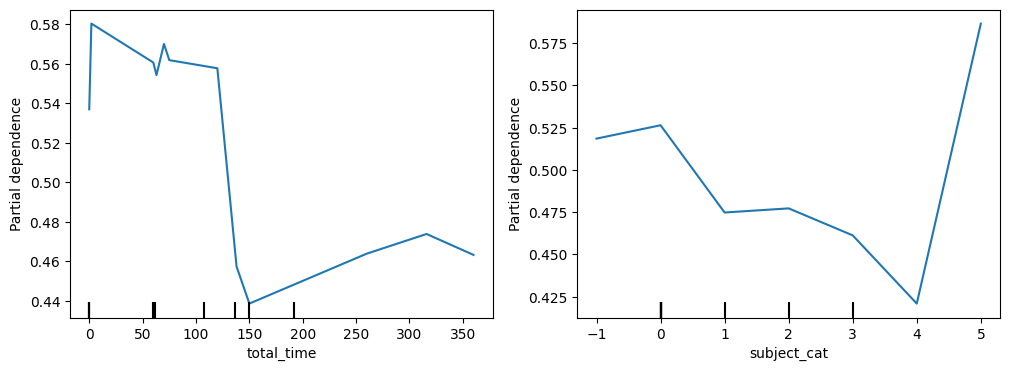

In [21]:
top2 = imp_df['feature'].iloc[:2].tolist()
fig, axes = plt.subplots(1, len(top2), figsize=(6*len(top2),4))
for i,f in enumerate(top2):
    PartialDependenceDisplay.from_estimator(rf_full, X, [features.index(f)], feature_names=features, ax=axes[i])
plt.show()


In [22]:
print("duration_missing vs cl_score:")
print(df2.groupby('duration_missing')['cl_score'].describe())


duration_missing vs cl_score:
                  count      mean       std       min       25%       50%  \
duration_missing                                                            
0                  22.0  0.523479  0.257880  0.000000  0.441239  0.485574   
1                  10.0  0.500000  0.196671  0.161858  0.363652  0.522168   

                       75%       max  
duration_missing                      
0                 0.709535  1.000000  
1                 0.603097  0.838142  


In [23]:
df2['alert_rule'] = (
    (df2['cl_score'] >= 0.75) |
    ((df2['total_time'] >= 120) & (df2['late_night'] == 1)) |
    ((df2['num_sessions'] >= 3) & (df2['switch_rate'] >= 1.0)) |
    ((df2['duration_missing'] == 1) & (df2['cl_score'] >= 0.6))
)
print("alerts count:", df2['alert_rule'].sum())
print(df2.loc[df2['alert_rule'], ['date','subject','cl_score','duration_missing','total_time','num_sessions','switch_rate']].head(10))


alerts count: 7
          date  subject  cl_score  duration_missing  total_time  num_sessions  \
1   2025-12-19   Coding  0.838142                 0        70.0           1.0   
8   2025-12-19    Other  1.000000                 0        60.0           1.0   
17  2025-12-19  Science  0.838142                 1         0.0           2.0   
19  2025-12-19      NaN  0.603097                 1         0.0           NaN   
21  2025-12-19     Math  1.000000                 0         2.0           1.0   
26  2025-12-19   Coding  0.676284                 1         0.0           2.0   
28  2025-12-19   Coding  0.603097                 1         0.0           NaN   

    switch_rate  
1           0.0  
8           0.0  
17          0.0  
19          0.0  
21          0.0  
26          0.0  
28          0.0  


In [ ]:
df2.to_csv('cognitive_load_model_ready_with_cl_1.csv', index=False)
# Save fitted RF and DT if desired
import joblib
joblib.dump(rf_full, 'rf_full_1.pkl')
joblib.dump(dt_full, 'dt_full_1.pkl')

['dt_full_1.pkl']

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# Load your saved dataset
df = pd.read_csv("cognitive_load_model_ready_with_cl_1.csv")

# Refit scaler ONLY on focus & fatigue
scaler = StandardScaler()
scaler.fit(df[['focus', 'fatigue']].values)

# Save it
joblib.dump(scaler, "scaler_1.pkl")

print("Scaler recreated and saved as scaler_1.pkl")


Scaler recreated and saved as scaler_1.pkl
